# Visualizations of apply benches

In [44]:
import matplotlib.pyplot as plt
import pandas as pd

In [49]:
# We load up the benchmark file with the Criterion benchmark results
benchmark = open("bench_apply.txt", "r").read()

# We split the file into lines and keep only the lines containing 'time:'
lines = benchmark.split("\n")

# We create a list of dictionaries, each dictionary containing the benchmark results for one function
results = []

for line in lines:
    if "time:" not in line:
        continue
    # A line containing time: looks liek this: "apply_u8_1    time:   [5.1796 µs 5.1824 µs 5.1863 µs]"
    parts = line.split("time:")
    name = parts[0].strip()
    time = parts[1].strip(" []")\
        .replace("µs", "")\
        .replace("  ", " ")

    # We retrieve the lower, average and upper bounds of the time
    time = time.split(" ")
    lower = float(time[0])
    average = float(time[1])
    upper = float(time[2])

    # We split the name, the word and the bitwidth.
    if name.startswith("apply_"):
        word = name.split("_")[1]
        window = int(name.split("_")[2])
        name = "apply"
    elif name.startswith("get_set"):
        word = name.split("_")[2]
        window = int(name.split("_")[3])
        name = "get/set"
    else:
        raise ValueError(f"Unknown name: {name}")

    # We add the results to the list
    results.append({
        "name": name,
        "word": word,
        "window": window,
        "lower": lower,
        "average": average,
        "upper": upper
    })

# We create a DataFrame from the list of dictionaries
df = pd.DataFrame(results)

# We create a new dataframe with the name of the function combined with the time
# columns so to better display and compare the results in a human readable way
apply_df = df[df["name"] == "apply"]
get_set_df = df[df["name"] == "get/set"]
apply_df = apply_df.drop(columns=["name"])
get_set_df = get_set_df.drop(columns=["name"])
apply_df.columns = ["word", "window", "lower_apply", "average_apply", "upper_apply"]
get_set_df.columns = ["word", "window", "lower_get_set", "average_get_set", "upper_get_set"]
# We sort both dataframes by word and window
apply_df = apply_df.sort_values(by=["word", "window"])
get_set_df = get_set_df.sort_values(by=["word", "window"])
# We drop the word and window columns from the get_set_df
get_set_df = get_set_df.drop(columns=["word", "window"])

human_df = pd.concat([
    apply_df.reset_index(drop=True),
    get_set_df.reset_index(drop=True)
], axis=1)

human_df.to_csv("bench_apply.csv", index=False)

human_df

,word,window,lower_apply,average_apply,upper_apply,lower_get_set,average_get_set,upper_get_set
0,u16,1,5.0566,5.0582,5.0602,24.119,24.1250,24.1330
1,u16,2,5.4323,5.4361,5.4407,20.604,20.6070,20.6110
2,u16,3,6.5078,6.5120,6.5189,24.858,24.8700,24.8850
3,u16,4,5.8888,5.8919,5.8958,15.769,15.7760,15.7850
4,u16,5,7.2983,7.3020,7.3068,26.193,26.2140,26.2360
...,...,...,...,...,...,...,...,...
115,u8,4,6.7923,6.7945,6.7974,12.611,12.6160,12.6230
116,u8,5,8.7428,8.7490,8.7570,25.014,25.0270,25.0440
117,u8,6,9.2977,9.3061,9.3178,19.776,19.7820,19.7910
118,u8,7,10.5270,10.5330,10.5400,24.837,24.8420,24.8480


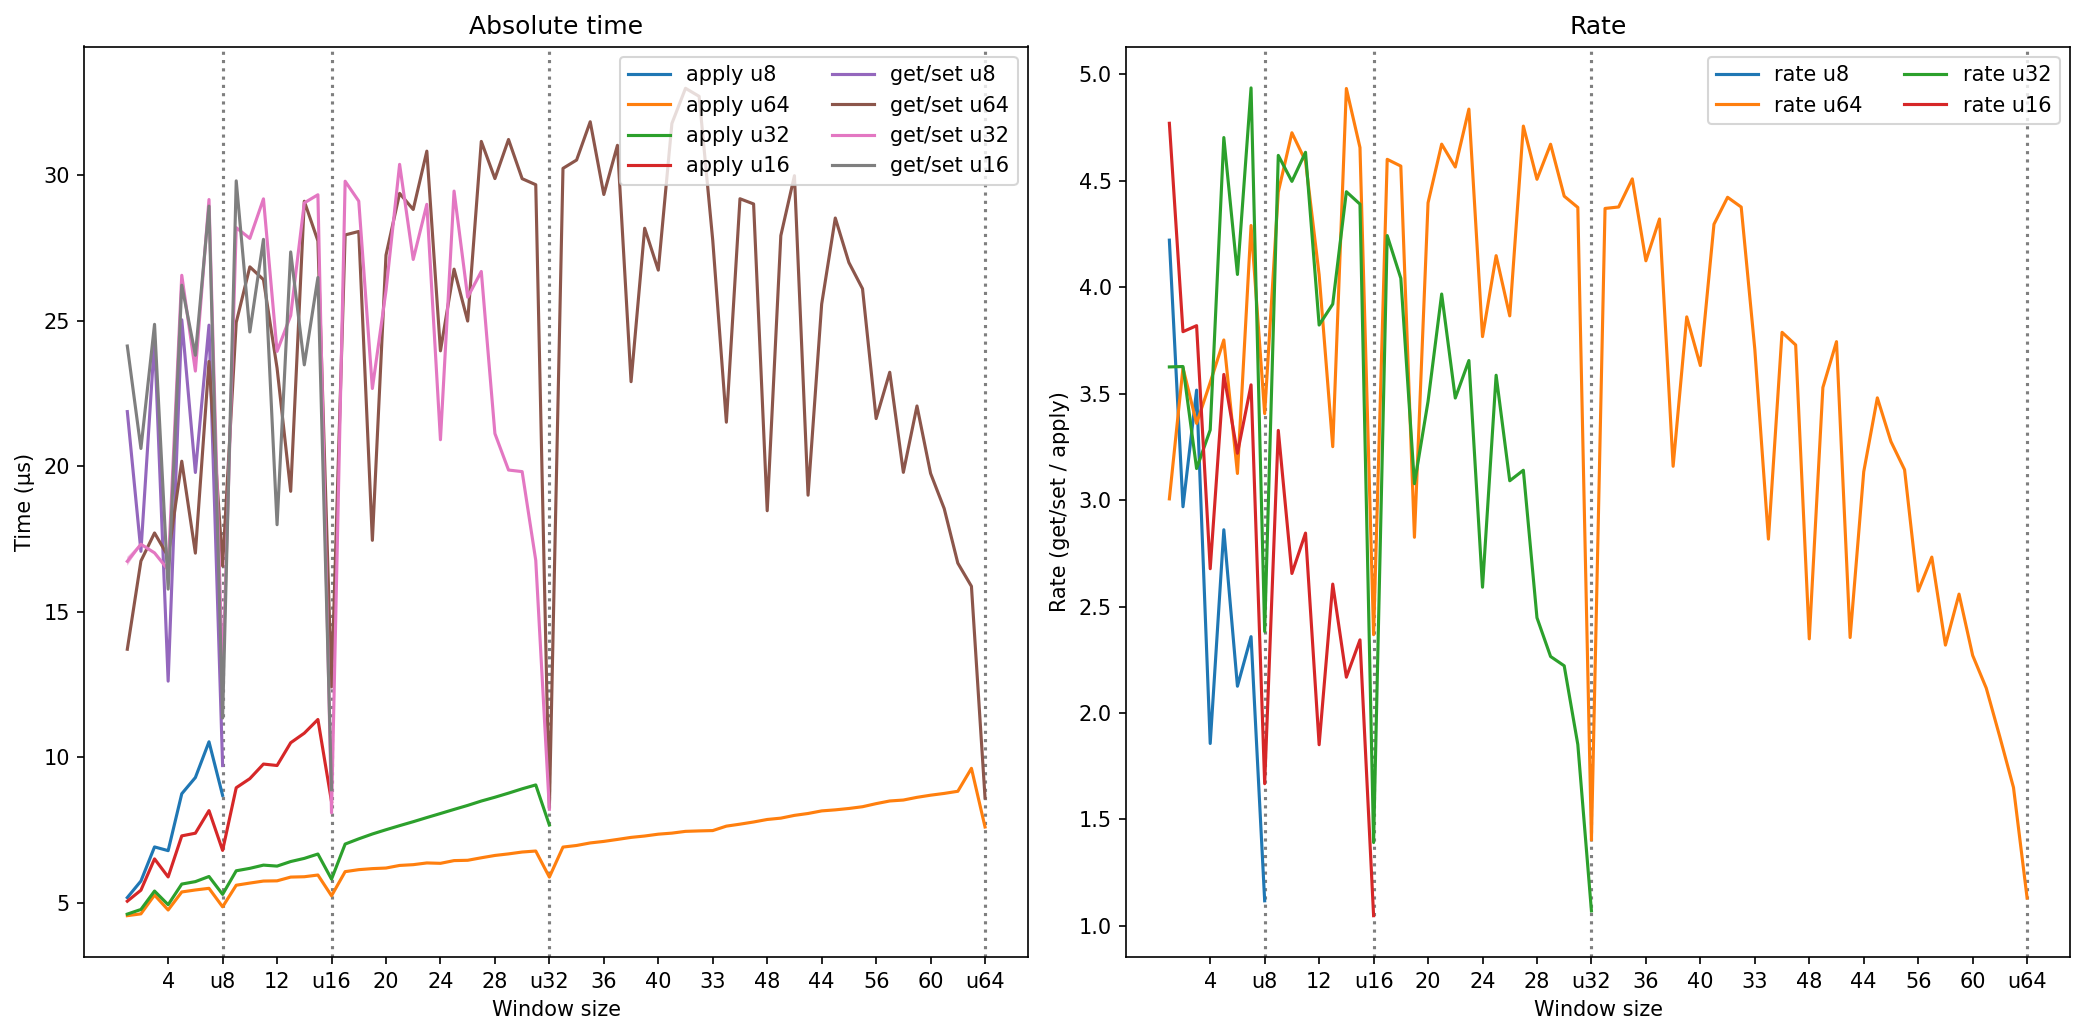

In [46]:
# We make two plots side by side
# In the first one we will plot the absolute values, while
# in the second one we will plot the rates between the get/set
# and apply functions
fig, axes = plt.subplots(1, 2, figsize=(14, 7), dpi=150)

# We make vertical lines at 8, 16, 32 and 64 to highlight the window sizes
# matching with the word sizes
for ax in axes:
    ax.axvline(8, color="black", linestyle=":", alpha=0.5)
    ax.axvline(16, color="black", linestyle=":", alpha=0.5)
    ax.axvline(32, color="black", linestyle=":", alpha=0.5)
    ax.axvline(64, color="black", linestyle=":", alpha=0.5)
    # We display the size of the word sizes on the x-axis
    ax.set_xticks([4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64])
    ax.set_xticklabels(["4", "u8", "12", "u16", "20", "24", "28", "u32", "36", "40", "33", "48", "44", "56", "60", "u64"])

for name in df.name.unique():
    for word in reversed(sorted(df.word.unique())):
        subdf = df[(df.name == name) & (df.word == word)]
        # We sort the values by the window size
        subdf = subdf.sort_values("window")

        # We color the area above and below the average time
        area = axes[0].fill_between(subdf.window, y1=subdf.lower, y2=subdf.upper, alpha=0.5)

        # We plot the average time using the same color as per the area
        axes[0].plot(
            subdf.window,
            subdf.average,
            label=f"{name} {word}",
            color=area.get_facecolor()[0],
            alpha=1.0
        )

        # We now plot the rate if the current word is an apply
        if name == "apply":
            # We retrieve the get/set function for the current word
            get_set = df[(df.name == "get/set") & (df.word == word)]
            get_set = get_set.sort_values("window")

            # We compute the rate as the ratio between the get/set and the apply
            rate = get_set.average.values / subdf.average.values
            axes[1].plot(
                subdf.window,
                rate,
                label=f"rate {word}",
                color=area.get_facecolor()[0],
                alpha=1.0
            )

for ax in axes:
    ax.set_xlabel("Window size")
    ax.legend(ncol=2)
axes[0].set_ylabel("Time (µs)")
axes[1].set_ylabel("Rate (get/set / apply)")
axes[0].set_title("Absolute time")
axes[1].set_title("Rate")
fig.tight_layout()
# We save the plot to a file
plt.savefig("bench_apply.jpg")